In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import poisson, nbinom
import seaborn as sns
import pandas as pd

from Model import Model
from PlaceInputs import PlaceInputs
from utils import *
import configs

# Parameters and Initialization

In [2]:
# Parameters
N_inp = 5000
N_bar = 5000
num_states = 100
steps = 100

In [3]:
place_inputs = PlaceInputs(N_inp, num_states).get_inputs()
model = Model(
    N_inp, N_bar, num_states,
    steps=steps
    )

In [58]:
cache_states = [0, 33, 66]

# Run Task (with learning)

In [59]:
model.reset()
cache_acts = []
cache_acts_over_time = []
retrieval_acts_over_time = []

for cache_state in cache_states:
    print("Now I just cached at location:", cache_state)
    preacts, acts, _, acts_over_time = model.run_recurrent(place_inputs, n_zero_input=20)
    model.update(place_inputs[cache_state], acts[cache_state], preacts[cache_state])
    cache_acts.append(acts.copy())
    cache_acts_over_time.append(acts_over_time.copy())

Now I just cached at location: 0
Now I just cached at location: 33
Now I just cached at location: 66


In [60]:
_, place_acts, _, _ = model.run_nonrecurrent(place_inputs)
place_mean = np.mean(place_acts, axis=0).flatten()
place_std = np.std(place_acts, axis=0).flatten()

# Define cache activity as a mean over some time window

In [61]:
start_t = steps-25 # Start of time window

In [62]:
avg_cache_acts = []
for i in range(len(cache_states)):
    location = cache_states[i]
    vec = cache_acts_over_time[i][start_t:steps, location, :].mean(axis=0)
    avg_cache_acts.append(vec)
avg_cache_acts = np.array(avg_cache_acts)

/share/apps/anaconda3-2019.03/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice.
  after removing the cwd from sys.path.


In [63]:
cache_mean = avg_cache_acts.mean(axis=0)

# Define barcodes

In [64]:
barcodes = []
for i in range(len(cache_states)):
    location = cache_states[i]
    
    # Cache activations
    _cache_act = avg_cache_acts[i].copy()
    _cache_act -= cache_mean
    
    # Place activations
    _place_act = place_acts[location].copy()
    _place_act -= place_mean
    _place_act /= np.linalg.norm(_place_act)
    
    # Define barcode
    projection = np.dot(_cache_act, _place_act) * _place_act
    barcode = _cache_act - projection
    barcodes.append(barcode)
barcodes = np.array(barcodes)

In [65]:
barcodes /= np.linalg.norm(barcodes, axis=1)[:,None]

# Run recall at some search strength

In [77]:
model.steps = 50

In [78]:
_, recall_acts, recall_reconstruct, recall_acts_over_time = model.run_recall(
    1.75, place_inputs, n_zero_input=0)

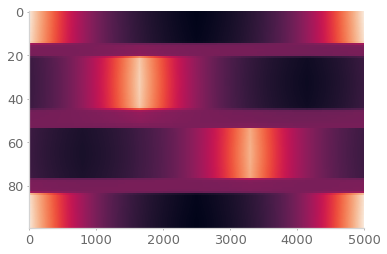

In [79]:
plt.figure()
plt.imshow(recall_reconstruct, aspect='auto')
plt.show()

In [83]:
locations = []
curr_place_proj_in_time = []
target_place_proj_in_time = []
barcode_proj_in_time = []

for i in range(len(cache_states)):
    location = cache_states[i] + 10
    _recall_act_over_time = recall_acts_over_time[:,location,:]
    
    # Curr location activity
    _curr_place_act = place_acts[location].copy()
    _curr_place_act -= place_mean
    _curr_place_act /= np.linalg.norm(_curr_place_act)
    
    # Target location activity
    _target_place_act = place_acts[cache_states[i]].copy()
    _target_place_act -= place_mean
    _target_place_act /= np.linalg.norm(_target_place_act)
    
    # Target cache activations
    _cache_act_over_time = cache_acts_over_time[i]
    _cache_act = avg_cache_acts[i].copy()
    _cache_act -= cache_mean
    
    # Over time
    _curr_place_proj_in_time = []
    _target_place_proj_in_time = []
    _barcode_proj_in_time = []
    for t in range(_recall_act_over_time.shape[0]):
        _r = _recall_act_over_time[t] # (n_units,)
        _r = _r / np.linalg.norm(_r)
        _curr_place_proj_in_time.append(np.dot(_r, _curr_place_act))
        _target_place_proj_in_time.append(np.dot(_r, _target_place_act))
        _barcode_proj_in_time.append(np.dot(_r, barcodes[i]))
    curr_place_proj_in_time.append(_curr_place_proj_in_time)
    target_place_proj_in_time.append(_target_place_proj_in_time)
    barcode_proj_in_time.append(_barcode_proj_in_time)

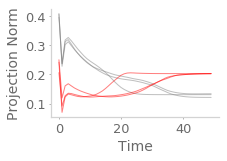

In [84]:
# Chettih et al Figure 7
plt.figure(figsize=(3,2))
for cpp in curr_place_proj_in_time:
    plt.plot(cpp, alpha=0.5, color='gray')
for tpp in target_place_proj_in_time:
    plt.plot(tpp, alpha=0.5, color='red')
# for bp in barcode_proj_in_time:
#     plt.plot(bp, alpha=0.5, color='orange')
plt.xlabel('Time')
plt.ylabel('Projection Norm')
plt.show()

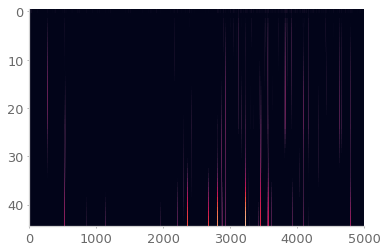

In [71]:
plt.figure()
plt.imshow(_recall_act_over_time, aspect='auto')
plt.show()